# Pre-Analysis of SL System SDSS J1627-0053
This notebook takes the drizzled HST images and extracts the information (e.g. cutout of image, PSF and noise estimates) to be used in the subsequent modelling process.

### import libraries

In [21]:
import numpy as np
import os
import h5py

import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util
from astroObjectAnalyser.DataAnalysis.analysis import Analysis
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

### read in data from fits files

In [22]:
system_name = 'SL2SJ020833-071414'

ra_str = '02:08:33.06'
dec_str = '-07:14:14.35'

# options for cutout
numPix = 180 # only even numbers allowed so far

system = StrongLensSystem(system_name)
system.add_info_attribute('ra_str', ra_str)
system.add_info_attribute('dec_str', dec_str)

image_name = 'F475X'
image_filename = '{}_F475X_drz_sci.fits'.format(system_name)
wht_filename = "{}_F475X_drz_wht.fits".format(system_name)
cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

# import the data
local_filename = os.path.join(base_path, 'data', 'reduced_data', image_filename)
local_wht_filename = os.path.join(base_path, 'data', 'reduced_data', wht_filename)


# add image data instance (see astroObjectAnalyser)
system.add_image_data_init(image_name, local_filename=local_filename, local_psf_filename=None, 
                    local_wht_filename=local_wht_filename,
                       ra=system.ra, dec=system.dec, ra_cutout_cent=system.ra, dec_cutout_cent=system.dec,
                       cutout_scale=numPix, data_type='HST_new')

print(system.ra, system.dec)
print(system.ra_str, system.dec_str)

/Users/chinyi/Desktop/Strong_Lensing/7_Feb
32.13775 -7.237319444444444
02:08:33.06 -07:14:14.35


## show image and determine shift and positions of point sources

the center of the image is at pixel coordinates 3282.241496, 2072.301879.


/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


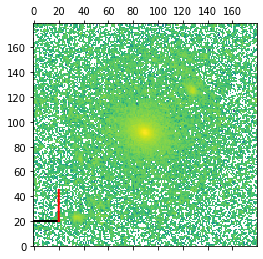

In [23]:
data_cutout = system.get_cutout_image(image_name, numPix, force=True)  # if force=True, a new cutout with the new options will be made

#%matplotlib notebook

plt.matshow(np.log10(data_cutout), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
plt.show()


0.0399999999999996
ccd gain = 1.5
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/chinyi/Desktop/Strong_Lensing/7_Feb/data/reduced_data/SL2SJ020833-071414_F475X_drz_sci.fits -c .pysex.sex -GAIN 1080.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw
0.0005913259810768 0.006429484579712
1.5
the center of the image is at pixel coordinates 3282.241496, 2072.301879.
separate exposure map loaded
(-803.3950658758401, -180.97555350812195)


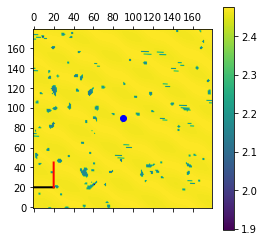

/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log10


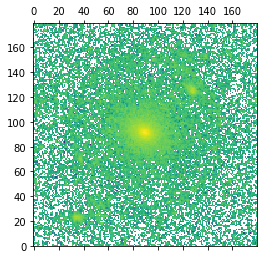

In [24]:
deltaPix, _ = system.get_pixel_scale(image_name)
deltaPix *= 3600  # convert into arcsec
print(deltaPix)
# get mean and sigma_bkd of image (computed by SourceExtractor)
mean, sigma_b = system.get_background(image_name)
ccd_gain = system.get_CCD_gain(image_name)
print(mean, sigma_b)
print(ccd_gain)

# we subtract the mean background estimate from the cutout image
data_reduced = (data_cutout - mean)#*mask_off


# get exposure time
exp_time = system.get_exposure_time(image_name)

# here we set the coordinate grid (rectangular)
ra_at_xy_0, dec_at_xy_0 = system.coord_at_pixel_0(image_name)
x_at_radec_0, y_at_radec_0 = system.pixel_at_angle_0(image_name)
Matrix = system.get_transform_matrix_angle2pix(image_name)
Matrix_inv = system.get_transform_matrix_pix2angle(image_name)
cos_dec = np.cos(system.dec/360*2*np.pi)


# get weight map (effective exposure time per pixel)
wht_map = system.get_exposure_map(image_name)
# untis in pixels are originally electrons/s
# we estimate the Poisson noise term in respect to a smaller IID count rate
wht_map /= 2.5 # 2.5 is equivalent to the CCD_gain parameter
# for numerics, replace 0 with small number
wht_map[wht_map <= 0] = 10**(-10)  # just making sure that there are non-negative exposure times


plt.matshow(np.log10(wht_map), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
 
print(system.coord2pix(image_name, system.ra+ra_at_xy_0, system.dec+dec_at_xy_0))

x_0, y_0 = system.pixel_at_angle_0(image_name)
plt.plot(x_0, y_0, 'ob')
plt.colorbar()
plt.show()



plt.matshow(np.log10(data_reduced), origin='lower')
plt.show()



In [25]:
# save data configurations ih hdf5 format
data_filename = 'data_f475x.hdf5'
local_data_filename = os.path.join(base_path, 'data', data_filename)
f = h5py.File(local_data_filename, "w")
dset = f.create_dataset('image_data', data=data_reduced)
dset = f.create_dataset('background_rms', data=sigma_b)
dset = f.create_dataset('exposure_time', data=wht_map)
dset = f.create_dataset('ra_at_xy_0', data=ra_at_xy_0)
dset = f.create_dataset('dec_at_xy_0', data=dec_at_xy_0)
dset = f.create_dataset('transform_pix2angle', data=Matrix_inv)
f.close()

### PSF estimate

No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/chinyi/Desktop/Strong_Lensing/7_Feb/data/reduced_data/SL2SJ020833-071414_F475X_drz_sci.fits -c .pysex.sex -GAIN 1080.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw
{'MagMaxThresh': 27.64759292602539, 'MagMinThresh': 24.925132751464844, 'SizeMinThresh': 0.4962491989135742, 'SizeMaxThresh': 4.496249198913574, 'EllipticityThresh': 0.1, 'ClassStarMax': 1.0, 'ClassStarMin': 0.5}
13 number of stars


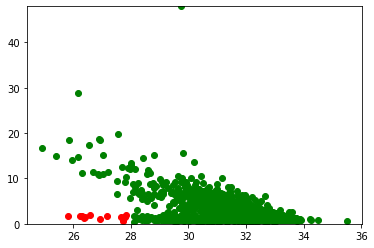

In [26]:
# options for PSF
psf_type ='pixel'
psf_size = 21
psf_size_large = 41
psf_symmetry = 4

# get SExtractor catalog
analysis = Analysis()
cat = system.get_cat(image_name)
#HDUFile, _ = system.get_HDUFile(image_name)
#import astropy.io.fits as pyfits
#HDUFile.writeto('pysex.cat')
#print HDUFile[2].data['X_WORLD']
#pyfits.writeto(filename='HDUFile.fits', data=HDUFile)
#print system.get_header(image_name)

# magnitude-size plot
mag = np.array(cat.data['MAG_BEST'],dtype=float)
mag[mag > 50] = np.mean(mag)
size = np.array(cat.data['FLUX_RADIUS'],dtype=float)

# select stars
kwargs_cuts = analysis.estimate_star_thresholds(cat)
print(kwargs_cuts)
kwargs_cuts['ClassStarMin'] = 0.1
kwargs_cuts['EllipticityThresh'] = 0.8
kwargs_cuts['MagMinThresh'] = 20
kwargs_cuts['MagMaxThresh'] = 28
kwargs_cuts['SizeMinThresh'] = 0.5
kwargs_cuts['SizeMaxThresh'] = 4
mask = analysis.find_objects(cat, kwargs_cuts)
print(np.sum(mask), 'number of stars')
plt.plot(mag[mask > 0], size[mask > 0], 'or')
plt.plot(mag[mask == 0], size[mask == 0], 'og')
plt.ylim([0, np.max(size)])
plt.show()


max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
=== object === 0 -0.97327756022433 -1.9318558516149482


/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/astroObjectAnalyser/DataAnalysis/analysis.py:71: RuntimeWarning: invalid value encountered in log10
  im = ax1.matshow(np.log10(sym_shifted), origin='lower', vmax=vmax, vmin=vmin)


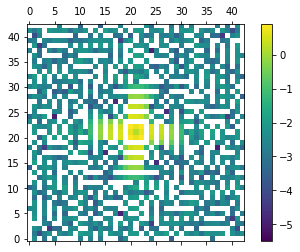

=== object === 1 -0.49973217507316986 -0.8601149733834061


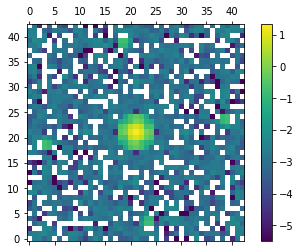

=== object === 2 -0.23453287274262735 -0.8499664542930817


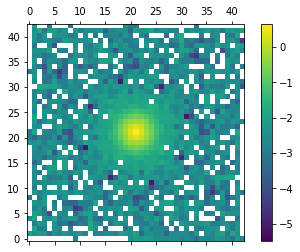

=== object === 3 1.3752578262484734 -0.3741018813237357


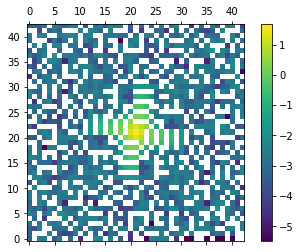

=== object === 4 -0.8692016964439441 -0.5136627530364103


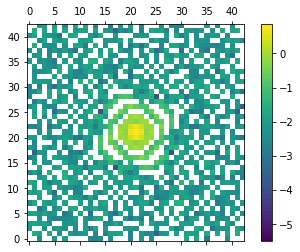

=== object === 5 -0.5989019592793134 -0.0662090417715413


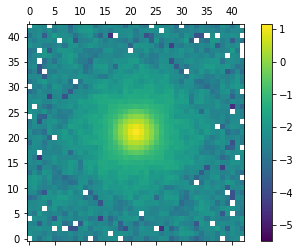

=== object === 6 -0.3995974555820062 1.104407576455222


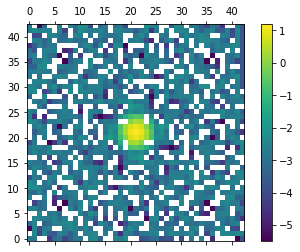

=== object === 7 -0.9668130937735199 1.36800216183555


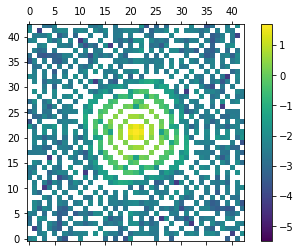

=== object === 8 -0.49154529107277845 -0.3674511119782906


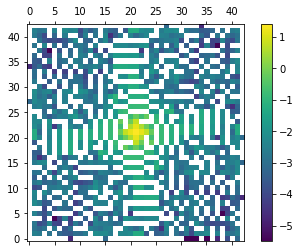

=== object === 9 -0.8763722763805761 -0.9084658627356352


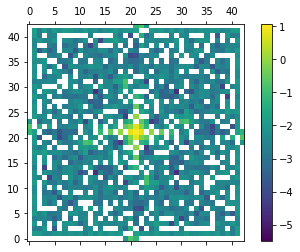

=== object === 10 -0.5784953807028184 -0.34132611879858604


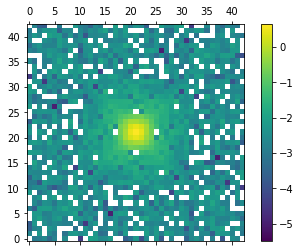

=== object === 11 -0.4722786606008598 -0.6978997070416495


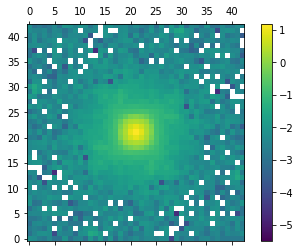

max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
max iteration reached! stoping
=== object === 0 -0.9663784446343766 -1.91299527938971


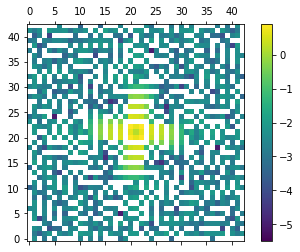

=== object === 3 1.4014642088063747 -0.39862152653945204


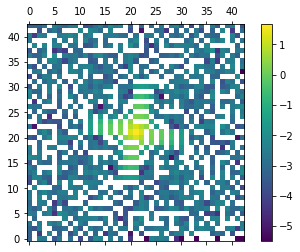

=== object === 4 -0.8690335425800708 -0.5075785442607905


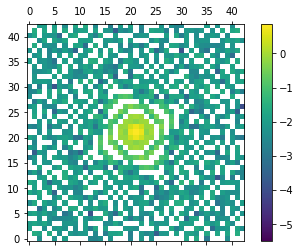

=== object === 7 -0.9508776866959334 1.370332399289073


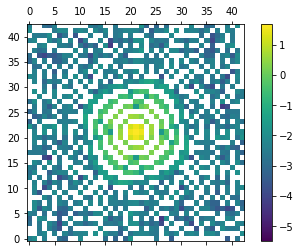

In [27]:
image_full = system.get_full_image(image_name)
image_full -= mean
kernel, mean_list, restrict_psf, star_list = analysis.get_psf(image_full, cat, mean, rms=sigma_b, poisson=exp_time,
                                psf_type='moffat', restrict_psf=None, kwargs_cut=kwargs_cuts, symmetry=psf_symmetry,
                                                             cutfixed=int(psf_size_large/2)+1,)

# restict psf fitting to subset of selected sources
#true_list = [17,21, 35]
true_list = [0, 3, 4, 7, 12, 18]
for i in range(len(restrict_psf)):
    if i not in true_list:
        restrict_psf[i] = False
kernel, mean_list, restrict_psf, star_list_shifted = analysis.get_psf(image_full, cat, mean, rms=sigma_b,
                                poisson=exp_time, psf_type='moffat', restrict_psf=restrict_psf, kwargs_cut=kwargs_cuts,
                                                                      symmetry=psf_symmetry,
                                                                     cutfixed=int(psf_size_large/2)+1)


1.0


/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


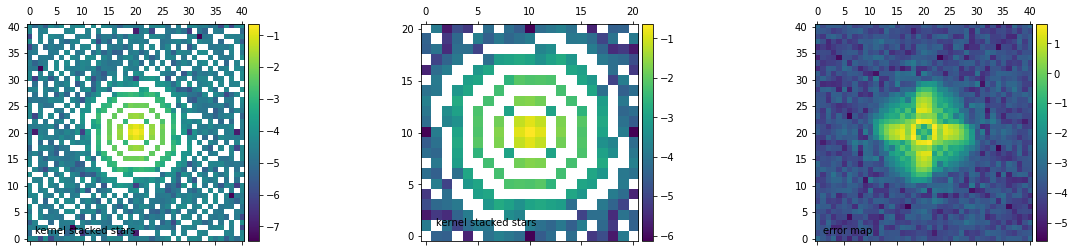

In [28]:
kernel_large_stack = kernel_util.cut_psf(kernel, psf_size=psf_size_large)
kernel_large_pixel = kernel #util.pixel_kernel(kernel)
kernel_pixel = kernel_util.cut_psf(kernel_large_pixel, psf_size=psf_size)
print(np.sum(kernel_large_stack))
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapelets = ShapeletSet()

kernel_list = shapelets.shapelet_basis_2d(num_order=10, beta=2, numPix=psf_size_large)
kernel_list.append(kernel_large_stack)
error_map = analysis.get_psf_errors(kernel_large_stack, sigma_b, star_list_shifted)


f, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=False, sharey=False)
ax = axes[0]
im = ax.matshow(np.log10(kernel_large_stack), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
im = ax.matshow(np.log10(kernel_pixel), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[2]
im = ax.matshow(np.log10(error_map), origin='lower')
ax.text(1, 1, 'error map')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

In [29]:
psf_filename = 'psf_f475x.hdf5'
local_psf_filename = os.path.join(base_path, 'data', psf_filename)
f = h5py.File(local_psf_filename, "w")
dset = f.create_dataset('kernel_point_source', data=kernel_large_stack)
dset = f.create_dataset('psf_error_map', data=error_map)

f.close()
